The goal of this notebook is to count whole and partial cells within each CF when the pixel is 300x300m, to check out potential edge effects.

In [1]:
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from pathlib import Path
import matplotlib.pyplot as plt
from rasterio.plot import show
from shapely.geometry import box
import numpy as np
import pandas as pd

In [2]:
code_path = Path().absolute()
datafd_path = code_path.parent.parent / 'data'
outfd_path = code_path.parent.parent / 'output'

In [3]:
# Read the CF polygon file
CF_path = datafd_path / 'CF' / 'Cambodia' / \
    'All_CF_Cambodia_July_2016_DISES_v1' / \
    'All_CF_Cambodia_July_2016_DISES_v1.shp'
polygons = gpd.read_file(CF_path)  # EPSG:3148

# Read the raster file
raster_file = datafd_path / 'DisturbanceData'/ 'year_of_disturbance_300m_1.tif'
raster = rasterio.open(raster_file, 'r+')  # EPSG:32648

### preprocess

In [4]:
polygons_proj = polygons.to_crs(raster.crs)

In [5]:
yod = raster.read(1)  # band 1

In [6]:
# Read the data from the raster
data = raster.read()

# Replace all the values with the 1 since the values don't matter here
data.fill(1)

# Write the updated data back to the raster dataset
raster.write(data)

### explore

#### explore raster

In [7]:
raster.count  # n bands

1

In [8]:
raster.width, raster.height

(888, 941)

In [9]:
raster.dtypes

('int16',)

In [10]:
raster.bounds

BoundingBox(left=432120.0, bottom=1315290.0, right=698520.0, top=1597590.0)

In [11]:
raster.crs

CRS.from_epsg(32648)

### visualize

<AxesSubplot:>

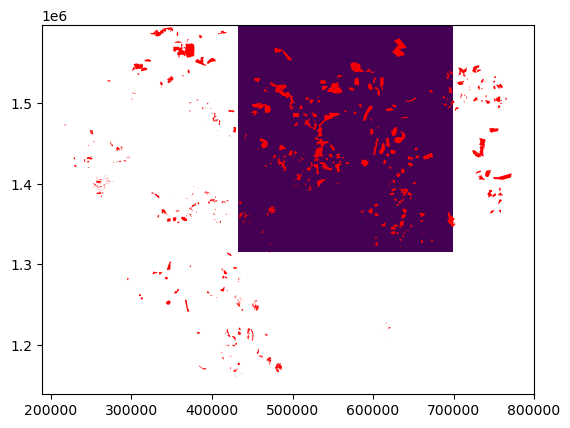

In [12]:
fig, ax = plt.subplots()
show(data, ax=ax, transform=raster.transform)
polygons_proj.plot(ax=ax, color='red')

### analyze

#### count whole and partial cells within polygons

##### one polygon

In [7]:
polygon0_gdf = polygons_proj.iloc[[72], :]  # 100, 59

<AxesSubplot:>

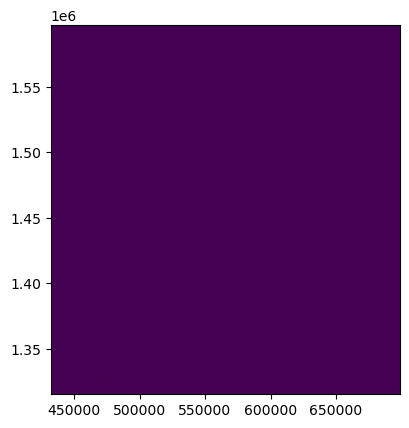

In [8]:
fig, ax = plt.subplots()
show(data, ax=ax, transform=raster.transform)
polygon0_gdf.plot(ax=ax, color='red')

In [9]:
# both whole and partial cells
mask0_both, mask0_both_transform = mask(
    raster, polygon0_gdf.geometry, all_touched=True, invert=False, crop=True
)

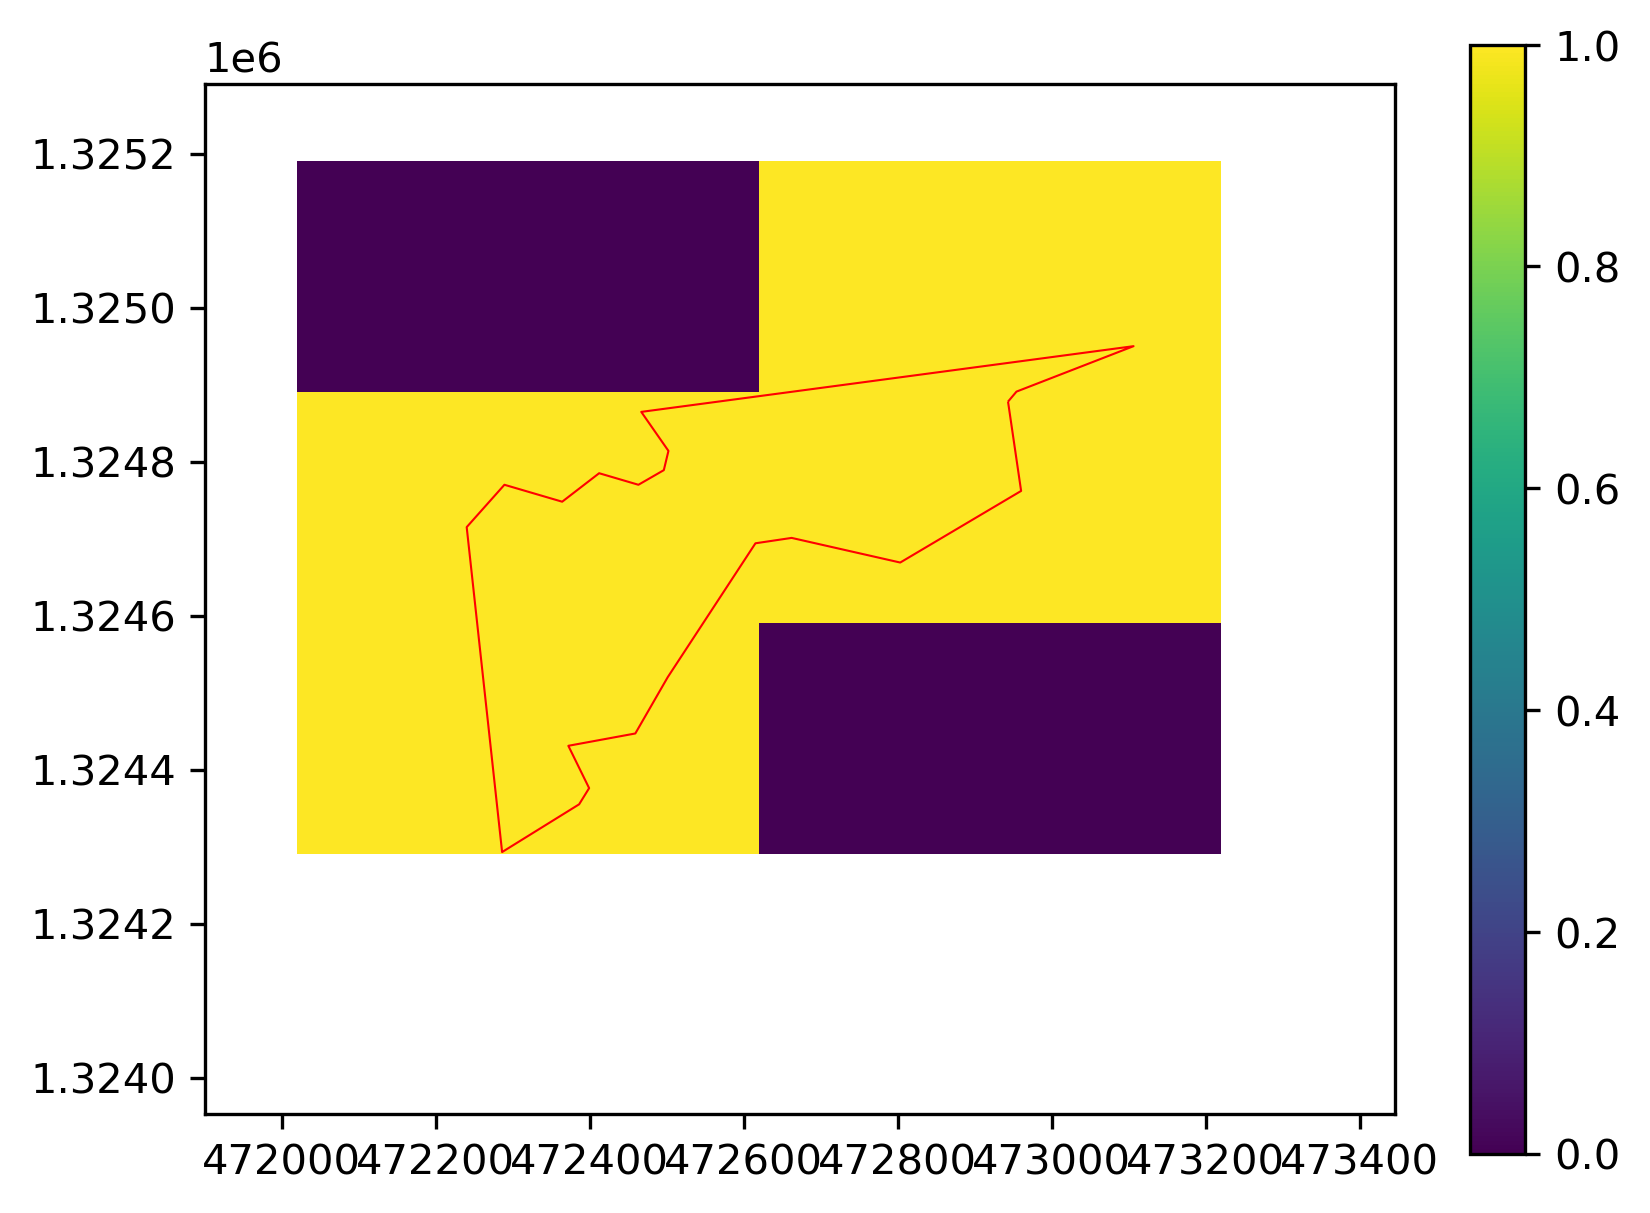

In [10]:
fig, ax = plt.subplots(dpi=300)
img = show(mask0_both, ax=ax, transform=mask0_both_transform)
polygon0_gdf.exterior.plot(ax=ax, color='red', lw=0.5)
minx, miny, maxx, maxy = polygon0_gdf.geometry.squeeze().bounds
plt.xlim(minx-340, maxx+340)
plt.ylim(miny-340, maxy+340)
fig.colorbar(img.get_images()[0], ax=ax)

In [11]:
mask0_both.sum()

8

In [12]:
# whole cells

In [13]:
raster_box = box(*list(raster.bounds))  # a rectangle with the same extent as the raster

In [14]:
# polygon: raster extent - the CF polygon
holed_polygon0 = raster_box.difference(polygon0_gdf.geometry.squeeze())

In [15]:
holed_polygon0_gdf = gpd.GeoDataFrame({'geometry': [holed_polygon0]}, crs=raster.crs)

In [16]:
# whole cells
mask0_whole, mask0_whole_transform = mask(
    raster, holed_polygon0_gdf.geometry, all_touched=True, invert=True, crop=False
)

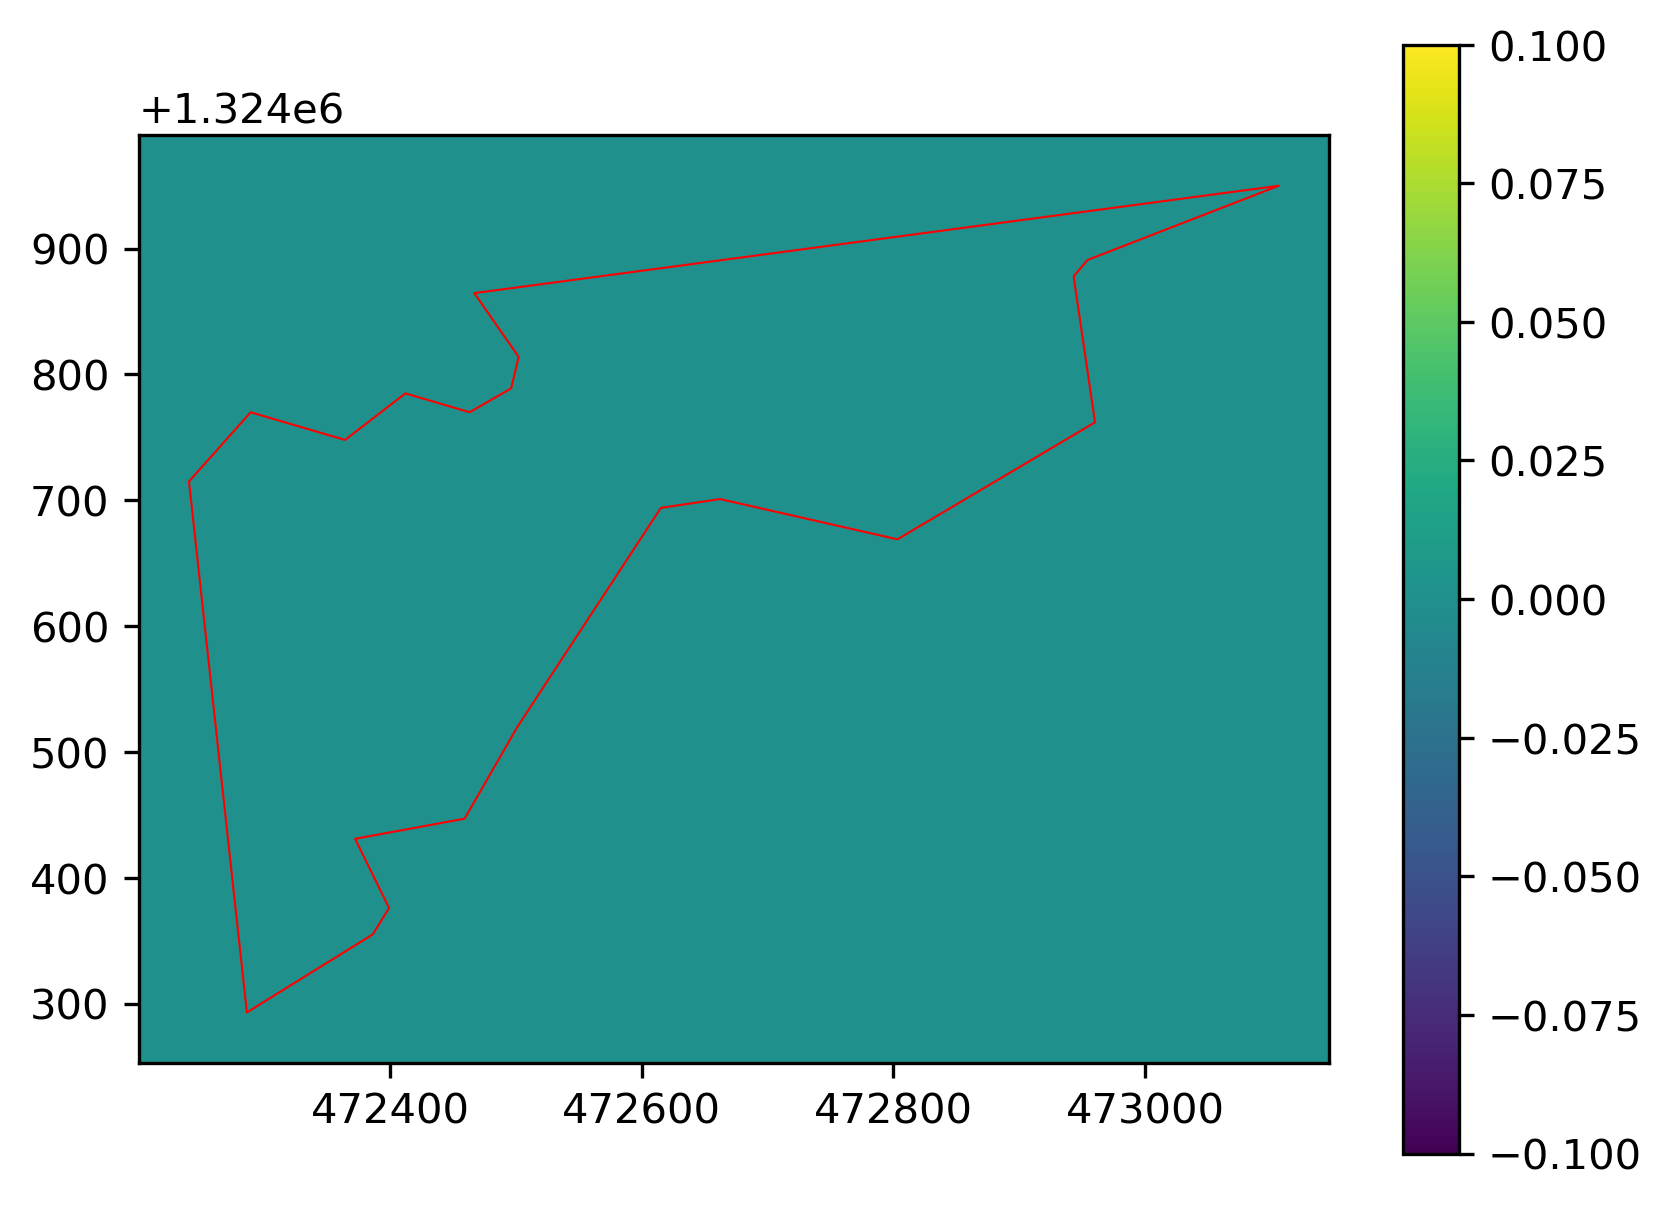

In [17]:
fig, ax = plt.subplots(dpi=300)
img = show(mask0_whole, ax=ax, transform=mask0_whole_transform)
polygon0_gdf.exterior.plot(ax=ax, color='red', lw=0.5)
minx, miny, maxx, maxy = polygon0_gdf.geometry.squeeze().bounds
plt.xlim(minx-40, maxx+40)
plt.ylim(miny-40, maxy+40)
fig.colorbar(img.get_images()[0], ax=ax)

In [18]:
mask0_whole.sum()

0

##### all polygons

In [7]:
def count_whole_n_partial_cells_in_polygon(polygon_gdf, raster):
    '''
    Counts 1) the RASTER cell within and/or intersects with
    the polygon in POLYGON_GDF (whole and partial cells), and 
    2) the RASTER cell that is entirely within the POLYGON (whole cells). 
    POLYGON_GDF should be in the same projection as RASTER. 
    '''
    raster_box = box(*list(raster.bounds))  # a rectangle boxing the raster
    polygon = polygon_gdf.geometry.squeeze()
    if not raster_box.contains(polygon):
        return np.nan, np.nan
    else:    
        # both whole and partial cells
        mask_both, mask_both_transform = mask(
            raster, polygon_gdf.geometry, all_touched=True, invert=False, crop=True
        )
        n = mask_both.sum()

        # whole cells
        # helper polygon: extent - polygon
        holed_polygon = raster_box.difference(polygon)
        holed_polygon_gdf = gpd.GeoDataFrame({'geometry': [holed_polygon]}, crs=raster.crs)

        mask_whole, mask_whole_transform = mask(
            raster, holed_polygon_gdf.geometry, all_touched=True, invert=True, crop=False
        )
        n_whole = mask_whole.sum()
        return n, n_whole

In [8]:
count_dict = {'N_Cell': [], 'N_Cell_Whl': []}
for i in range(polygons_proj.shape[0]):
    polygon_gdf = polygons_proj.iloc[[i], :]
    N_Cell, N_Cell_Whl = count_whole_n_partial_cells_in_polygon(polygon_gdf, raster)
    count_dict['N_Cell'].append(N_Cell)
    count_dict['N_Cell_Whl'].append(N_Cell_Whl)

In [9]:
raster.close()

In [10]:
polygons_w_counts = pd.concat([polygons_proj, pd.DataFrame(count_dict)], axis=1)
polygons_w_counts

,CF_Code,Code_Srok,Code_Khum,No_Village,CF_Name_En,CF_Name_Kh,Commune,Khum,District,Srok,...,Agreement,NCF_statis,Year_CFMP,FA_Can,UniqueID,Why_Remove,Overlap_Pa,geometry,N_Cell,N_Cell_Whl
0,10406.0,104.0,10405.0,1.0,Poy Tapen,e):aytaEb:n,Preah Netrpreah,RBHenRtRBH,Preah Netrpreah,RBHenRtRBH,...,CFA,NCF,0,NaN,1,NaN,0,"POLYGON ((301287.874 1504405.804, 301227.865 1...",NaN,NaN
1,10405.0,104.0,10402.0,2.0,Phnom Chuncheang,PMñCBa¢aMg,Chub Veary,Cb;varI,Preah Netrpreah,RBHenRtRBH,...,CFA,NCF,0,NaN,2,NaN,0,"POLYGON ((300966.829 1505821.921, 300951.827 1...",NaN,NaN
2,10403.0,104.0,10402.0,1.0,Trapeang Russei Lech,RtBaMgb¤sISlic,Chub Veary,Cb;varI,Preah Netrpreah,RBHenRtRBH,...,CFA,NCF,0,NaN,3,NaN,0,"POLYGON ((300724.793 1513459.554, 300818.806 1...",NaN,NaN
3,10809.0,108.0,10804.0,1.0,Ponsay Cheung,BnSayeCIg,Svay Chek,sVayeck,Svay Chek,sVayeck,...,CFA,NCF,0,NaN,4,NaN,0,"POLYGON ((271087.739 1528642.825, 271405.783 1...",NaN,NaN
4,10808.0,108.0,10801.0,1.0,Prasat Vean,R)asaTevon,Pkoam,pÁaM,Svay Chek,sVayeck,...,CFA,NCF,0,NaN,5,NaN,0,"POLYGON ((308944.906 1537202.518, 309068.923 1...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,110403.0,1104.0,110403.0,1.0,Phum Puradet,puMIbuR:AeDT,Srae Ampoum,ERsGMBUm,Pech Chreada,eBRCada,...,CFA,NCF,0,NaN,670,Updated with R194 were necisary,16,"POLYGON ((759020.280 1389871.211, 759020.278 1...",NaN,NaN
635,0.0,0.0,0.0,1.0,Phnom Dek Chambok Has,PñMEdkcMbk;ehaH,Romoniey,rmNIy_,Rovieng,revog,...,CFA,NCF,0,NaN,672,NaN,0,"POLYGON ((505660.772 1472468.125, 505432.741 1...",125.0,64.0
636,0.0,0.0,0.0,0.0,Thnol Keng Trapeang Pcheck,fñl;EkgRtBaMgp©wk,Rong Roeung,rugÁerOg,Rovieng,rev[g,...,CFA,NCF,0,NaN,673,NaN,0,"POLYGON ((505660.772 1472468.125, 505578.761 1...",80.0,35.0
637,0.0,0.0,0.0,0.0,O Da,GUrda,Chang Krang,cRgág,NaN,NaN,...,NaN,NCF,0,FAC,674,NaN,0,"POLYGON ((628287.394 1392752.331, 628083.018 1...",190.0,118.0


In [26]:
# polygons_w_counts.to_file(
#     datafd_path / 'CF' / 'Cambodia' / 'All_CF_Cambodia_July_2016_DISES_v1_32648_n300mCell' / \
#     'All_CF_Cambodia_July_2016_DISES_v1_32648_n300mCell.shp'
# )

histograms

In [11]:
count_df = polygons_w_counts.iloc[:, -2:].dropna()

In [12]:
n_cell_partial = count_df.N_Cell - count_df.N_Cell_Whl

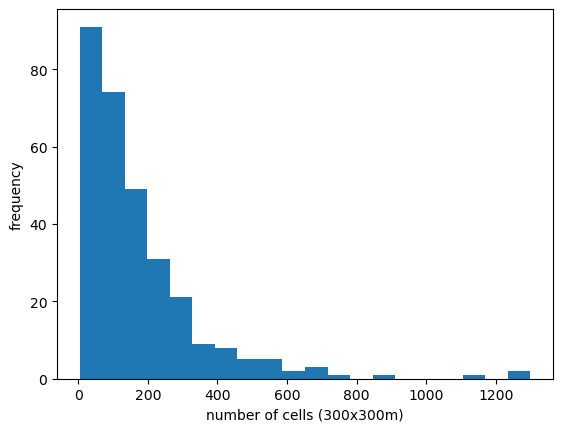

In [18]:
plt.hist(count_df.N_Cell, bins=20)
plt.xlabel('number of cells (300x300m)')
plt.ylabel('frequency')
plt.savefig(outfd_path / 'figures'/ 'khm_CF_ncell_300m.png')

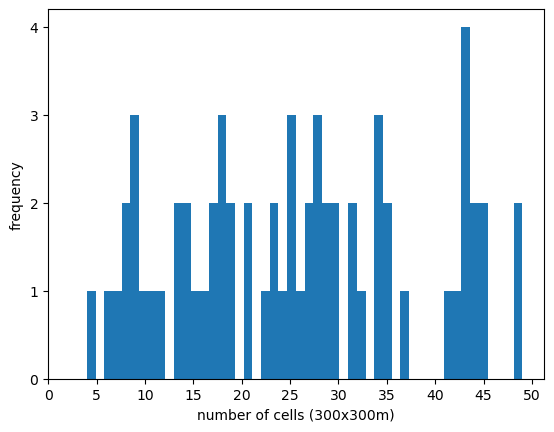

In [25]:
plt.hist(count_df.loc[count_df.N_Cell <= 50, 'N_Cell'], bins=50)
plt.xticks(np.arange(0,51,5))
plt.xlabel('number of cells (300x300m)')
plt.yticks(range(5))
plt.ylabel('frequency')
plt.savefig(outfd_path / 'figures'/ 'khm_CF_ncell_300m_le50.png', dpi=300)

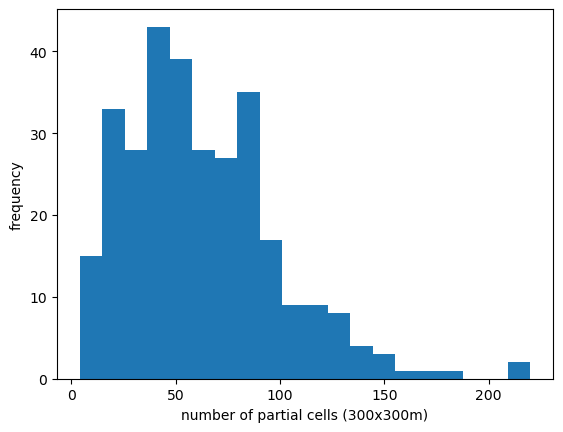

In [47]:
plt.hist(n_cell_partial, bins=20)
plt.xlabel('number of partial cells (300x300m)')
plt.ylabel('frequency')
plt.savefig(outfd_path / 'figures'/ 'khm_CF_ncell_partial_300m.png')

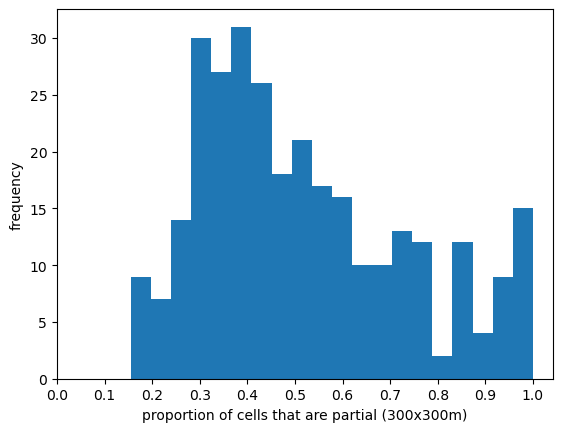

In [27]:
pct_cell_partial = n_cell_partial / count_df.N_Cell
plt.hist(pct_cell_partial, bins=20)
plt.xticks(np.arange(0,1.01,0.1))
plt.xlabel('proportion of cells that are partial (300x300m)')
plt.ylabel('frequency')
plt.savefig(outfd_path / 'figures'/ 'khm_CF_pctcell_partial_300m.png', dpi=300)